# DBSCAN Clustering Analysis
In this notebook we explore the usage of the **DBSCAN clustering algorithm** applied on the Customers' dataset we extracted in the previous step. 


We analyze **6 kind** of different approaches:
1. on the full dataset, picking the best hyperparameters according to the silhouette
2. on the full dataset, picking the best hyperparameters according to the silhouette (w/o noise)
3. on a manually selected subset of the dataset, picking the best hyperparameters according to the silhouette
4. on a manually selected subset of the dataset, picking the best hyperparameters according to the silhouette (w/o noise)
5. on a reduced dataset (PCA=2), picking the best hyperparameters according to the silhouette
6. on a reduced dataset (PCA=2), picking the best hyperparameters according to the silhouette (w/o noise)


The hyperparameters we tune are the **eps** and **n_samples**, according to the following grid search:
- eps: {0.1, 0.2, 0.3, 0.4, 0.5}
- n_samples: {1, 2, 5, 10, 15, 20, 25, 30, 35, 40}

In [11]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from collections import defaultdict
from scipy.stats.stats import pearsonr
from copy import deepcopy
from IPython.display import display, Markdown, Latex
from sklearn.decomposition import PCA
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
warnings.filterwarnings('ignore')

img = 'plots/figure_{}.png'
dataFolder = '../../data/{}'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
np. set_printoptions(precision=3)

def load_dataset(cols=None):

    if cols is not None:
            df = pd.read_csv(dataFolder.format('customer_behavior_wo_noise.csv'), usecols=cols)
    else:
        df = pd.read_csv(dataFolder.format('customer_behavior_wo_noise.csv'))
    df = df.set_index('CustomerID')
    idx = deepcopy(df.index)
    cols = list(df.columns)
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df))
    df.index = idx
    df.columns = cols
    display(df.head())
    return df

def visualize_in_2d(df):
    display(Markdown('### Visualization in 2D'))
    plt.figure()
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    principalDf = pd.DataFrame(data = principalComponents, columns= ['principal component 1', 'principal component 2'])
    plt.title("Visualization of the Customers")
    plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], s=10)
    plt.show()
    display(Markdown('## '))


def analyze_PCA_dimensions(df, n=None):
    display(Markdown('### Analysis of the PCA'))

    if n is None:
        n = len(df.columns)-1
        
    pca = PCA(n_components=n)
    pca.fit(df)
    variance = pca.explained_variance_ratio_ 
    var=np.cumsum(np.round(variance, 3)*100)
    plt.figure()
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.ylim(0,100.5)
    plt.plot(var)
    plt.show()
    display(Markdown('## '))


def reduce_df_to_n_dimensions(df, n):
    reduced_df = PCA(n_components=n).fit_transform(df)
    reduced_df = pd.DataFrame(reduced_df, columns=['pc1', 'pc2'])
    return reduced_df

def grid_search(df, order_by):
    display(Markdown('### Gridsearch results'))

    ns = []
    eps = []
    sil_wn = []
    sil = []
    nlab = []
    labels_da_riutilizzare = {}

    for s in [1, 2, 5, 10, 15, 20, 25, 30, 35, 40]:
        for e in  np.arange(0.1, 0.5, 0.1):

            dbscan = DBSCAN(eps=e, min_samples=s)
            dbscan.fit(df)

            try:
                n = len(set(dbscan.labels_))-1
                if n > 1:
                    temp_df = deepcopy(reduced_df)
                    temp_df['labels'] = dbscan.labels_
                    temp_df=temp_df[temp_df['labels']>-1]
                    labels = deepcopy(temp_df['labels'])
                    del temp_df['labels']

                    score_wn = silhouette_score(temp_df, labels)
                    score = silhouette_score(reduced_df, dbscan.labels_)

                    if score > 0 and score_wn > 0:
                        nlab.append(n)
                        ns.append(s)
                        eps.append(e)
                        sil.append(score)
                        sil_wn.append(score_wn)
            except:
                continue

    results = pd.DataFrame({'samples':ns, 
                            'eps':eps, 
                            'silhouette': sil,
                            'silhouette (w/o noise)':sil_wn, 
                            '|labels|  (w/o noise label)':nlab}
                          )
    #display(results)
    results = results.sort_values(order_by, ascending=False).reset_index()
    del results['index']
    display(results.head())
    display(Markdown('## '))
    return results

def run_experiments(df, results, row_to_take=0):

    e = results['eps'].iloc[row_to_take]
    s = results['samples'].iloc[row_to_take]
  
    display(Markdown('### Running the experimentation'))
    print(f"eps: {e}, n_samples={s}")

    dbscan = DBSCAN(eps=e, min_samples=s)
    dbscan.fit(df)
    
    reduced_df = PCA(n_components=2).fit_transform(df)
    reduced_df = pd.DataFrame(reduced_df, columns=['pc1', 'pc2'])

    print("Labels found (w/o noise): ",len(set(dbscan.labels_))-1)
    reduced_df['labels'] = dbscan.labels_
    plt.figure()
    plt.scatter(reduced_df['pc1'], reduced_df['pc2'], c=dbscan.labels_, s=20, cmap='Spectral')
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title("DBSCAN with noise")
    plt.show()

    reduced_df['labels'] = dbscan.labels_
    reduced_df = reduced_df.set_index(df.index)
    reduced_df_cleaned = reduced_df[reduced_df['labels']>-1]
    plt.scatter(reduced_df_cleaned['pc1'], reduced_df_cleaned['pc2'], c=reduced_df_cleaned['labels'], s=20, cmap='Spectral')
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title("DBSCAN without noise")
    plt.show()
    return reduced_df_cleaned

# Considering all the features

,Money Spent Entropy,Mean Qta Q1,Mean Money Spent Q1,Mean Qta Q2,Mean Money Spent Q2,Mean Qta Q3,Mean Money Spent Q3,Distinct Products,Mean Days btw Purchases,Min Days btw Purchases,Max Days btw Purchases,Max Products In Basket,Min Products In Basket,Mean Products In Basket,Total Products,Distinct Baskets
CustomerID,,,,,,,,,,,,,,,,
12347,1.559384,0.791336,1.097669,1.176657,1.094506,0.960585,0.853072,1.800623,-0.625370,-0.827688,-0.453614,1.338817,-0.381238,0.746764,2.670643,1.092817
12349,0.720174,-0.872030,-0.918653,-0.975782,-1.021626,0.932301,1.074653,0.483574,1.192229,1.191851,1.156081,2.268802,4.771140,3.968380,0.410177,-0.643752
12350,-0.023469,1.799320,1.202418,-0.975782,-1.021626,-1.090054,-1.165732,-0.366135,1.192229,1.191851,1.156081,0.202168,1.447025,0.879159,-0.189539,-0.643752
12352,0.794202,1.503409,1.382503,-0.975782,-1.021626,0.805904,1.235288,0.313632,-0.908171,-1.015924,-0.692087,-0.521153,-0.879855,-0.599254,0.552417,1.092817
12353,-1.723677,-0.872030,-0.918653,0.698337,1.134816,-1.090054,-1.165732,-0.918445,1.192229,1.191851,1.156081,-1.141143,-0.713649,-1.128835,-0.796943,-0.643752


### Visualization in 2D

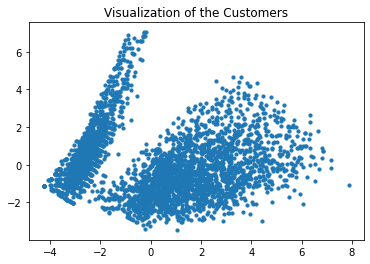

## 

### Analysis of the PCA

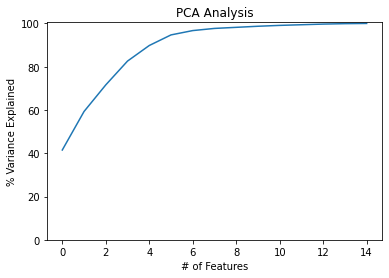

## 

### Gridsearch results

,samples,eps,silhouette,silhouette (w/o noise),|labels| (w/o noise label)
0,25,0.3,0.073672,0.967373,2
1,30,0.3,0.073672,0.967373,2
2,25,0.2,0.072718,0.973315,2
3,30,0.2,0.072718,0.973315,2
4,25,0.1,0.070899,0.983228,2


## 

### Running the experimentation

eps: 0.30000000000000004, n_samples=25
Labels found (w/o noise):  2


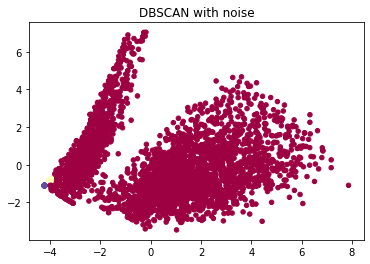

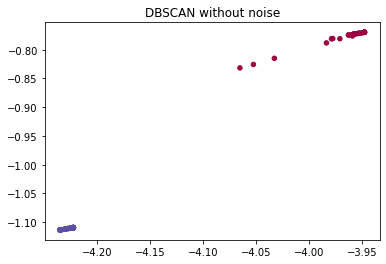

,pc1,pc2,labels
44,-3.947621,-0.769665,0
133,-4.222148,-1.109380,1
139,-3.952631,-0.771259,0
162,-4.224653,-1.110177,1
201,-4.234674,-1.113365,1
345,-4.229664,-1.111771,1
350,-4.222148,-1.109380,1
482,-4.222148,-1.109380,1
485,-4.222148,-1.109380,1
496,-3.957642,-0.772854,0


In [2]:
df = load_dataset()
visualize_in_2d(df)
analyze_PCA_dimensions(df)
reduced_df = reduce_df_to_n_dimensions(df, 2)
results = grid_search(df=df, order_by='silhouette')
run_experiments(df, results)


# Considering all the features (taking the best config according to silhouette without noise)

,Money Spent Entropy,Mean Qta Q1,Mean Money Spent Q1,Mean Qta Q2,Mean Money Spent Q2,Mean Qta Q3,Mean Money Spent Q3,Distinct Products,Mean Days btw Purchases,Min Days btw Purchases,Max Days btw Purchases,Max Products In Basket,Min Products In Basket,Mean Products In Basket,Total Products,Distinct Baskets
CustomerID,,,,,,,,,,,,,,,,
12347,1.559384,0.791336,1.097669,1.176657,1.094506,0.960585,0.853072,1.800623,-0.625370,-0.827688,-0.453614,1.338817,-0.381238,0.746764,2.670643,1.092817
12349,0.720174,-0.872030,-0.918653,-0.975782,-1.021626,0.932301,1.074653,0.483574,1.192229,1.191851,1.156081,2.268802,4.771140,3.968380,0.410177,-0.643752
12350,-0.023469,1.799320,1.202418,-0.975782,-1.021626,-1.090054,-1.165732,-0.366135,1.192229,1.191851,1.156081,0.202168,1.447025,0.879159,-0.189539,-0.643752
12352,0.794202,1.503409,1.382503,-0.975782,-1.021626,0.805904,1.235288,0.313632,-0.908171,-1.015924,-0.692087,-0.521153,-0.879855,-0.599254,0.552417,1.092817
12353,-1.723677,-0.872030,-0.918653,0.698337,1.134816,-1.090054,-1.165732,-0.918445,1.192229,1.191851,1.156081,-1.141143,-0.713649,-1.128835,-0.796943,-0.643752


### Visualization in 2D

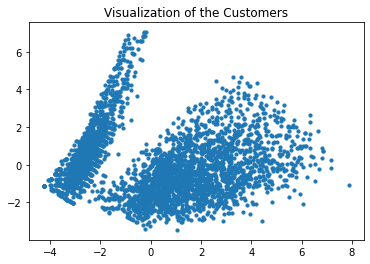

## 

### Analysis of the PCA

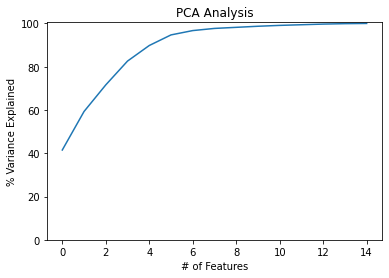

## 

### Gridsearch results

,samples,eps,silhouette,silhouette (w/o noise),|labels| (w/o noise label)
0,25,0.1,0.070899,0.983228,2
1,15,0.1,0.045242,0.974317,3
2,20,0.1,0.045242,0.974317,3
3,25,0.2,0.072718,0.973315,2
4,30,0.2,0.072718,0.973315,2


## 

### Running the experimentation

eps: 0.1, n_samples=25
Labels found (w/o noise):  2


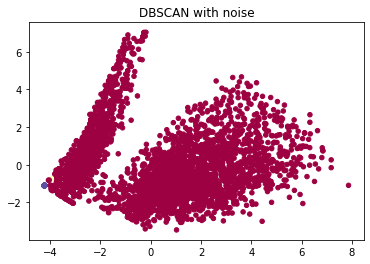

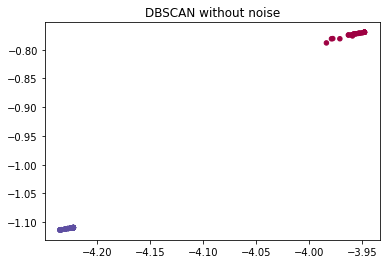

,pc1,pc2,labels
44,-3.947621,-0.769665,0
133,-4.222148,-1.109380,1
139,-3.952631,-0.771259,0
162,-4.224653,-1.110177,1
201,-4.234674,-1.113365,1
345,-4.229664,-1.111771,1
350,-4.222148,-1.109380,1
482,-4.222148,-1.109380,1
485,-4.222148,-1.109380,1
496,-3.957642,-0.772854,0


In [3]:
df = load_dataset()
visualize_in_2d(df)
analyze_PCA_dimensions(df)
reduced_df = reduce_df_to_n_dimensions(df, 2)
results = grid_search(df=df, order_by='silhouette (w/o noise)')
run_experiments(df, results)

# Trying without considering all the features

,Money Spent Entropy,Mean Days btw Purchases,Mean Products In Basket
CustomerID,,,
12347,1.559384,-0.625370,0.746764
12349,0.720174,1.192229,3.968380
12350,-0.023469,1.192229,0.879159
12352,0.794202,-0.908171,-0.599254
12353,-1.723677,1.192229,-1.128835


### Visualization in 2D

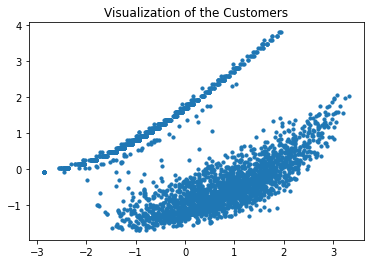

## 

### Analysis of the PCA

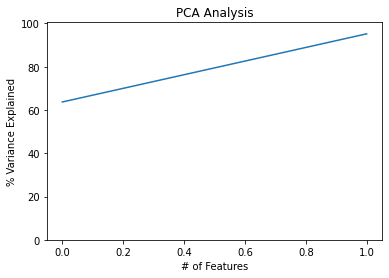

## 

### Gridsearch results

,samples,eps,silhouette,silhouette (w/o noise),|labels| (w/o noise label)
0,40,0.4,0.475144,0.535907,2
1,35,0.4,0.474933,0.531962,2
2,30,0.4,0.468353,0.525333,2
3,15,0.4,0.444625,0.511436,2
4,20,0.4,0.442449,0.512617,2


## 

### Running the experimentation

eps: 0.4, n_samples=40
Labels found (w/o noise):  2


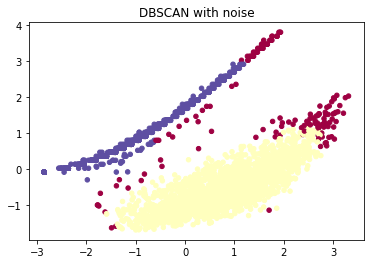

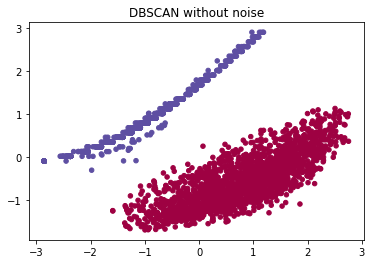

In [12]:
df = load_dataset(['CustomerID','Mean Days btw Purchases', 'Mean Products In Basket', 'Money Spent Entropy'])
visualize_in_2d(df)
analyze_PCA_dimensions(df)
reduced_df = reduce_df_to_n_dimensions(df, 2)
results = grid_search(df=df, order_by='silhouette')
cluster_cleaned = run_experiments(df, results)


## Characterization of the latest without noise


In [16]:
cleaned = df[df.index.isin(cluster_cleaned.index)]
cleaned = cleaned.join(cluster_cleaned[['labels']], on='CustomerID')
display(cluster_cleaned.head())

,pc1,pc2,labels
CustomerID,,,
12347,1.780899,0.100586,0
12350,-0.192853,1.460268,1
12352,0.722410,-1.063440,0
12353,-2.378536,0.017680,1
12354,0.878589,2.572025,1


,Money Spent Entropy,Mean Days btw Purchases,Mean Products In Basket,labels
CustomerID,,,,
12347,1.559384,-0.625370,0.746764,0
12350,-0.023469,1.192229,0.879159,1
12352,0.794202,-0.908171,-0.599254,0
12353,-1.723677,1.192229,-1.128835,1
12354,0.408198,1.192229,2.423769,1


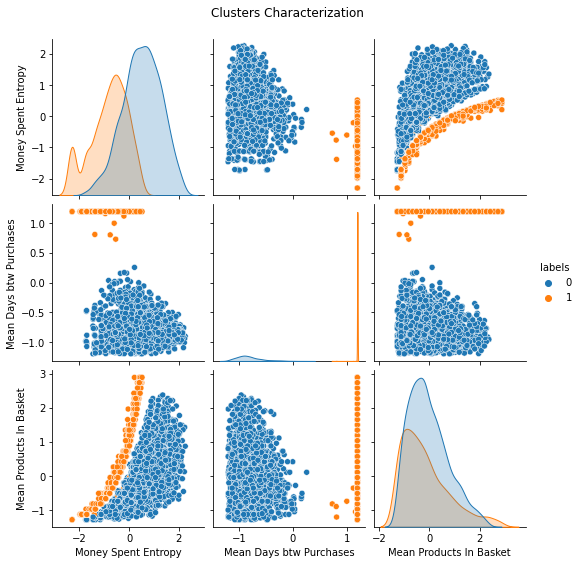

In [27]:
display(cleaned.head())
g = sns.pairplot(cleaned,hue='labels')
g.fig.suptitle("Clusters Characterization", y=1.04) 
g.savefig(img.format("dbscan_clusters_characterization"))

# Trying without considering all the features (taking the best config according to silhouette without noise)

,Money Spent Entropy,Mean Days btw Purchases,Mean Products In Basket
CustomerID,,,
12347,1.559384,-0.625370,0.746764
12349,0.720174,1.192229,3.968380
12350,-0.023469,1.192229,0.879159
12352,0.794202,-0.908171,-0.599254
12353,-1.723677,1.192229,-1.128835


### Visualization in 2D

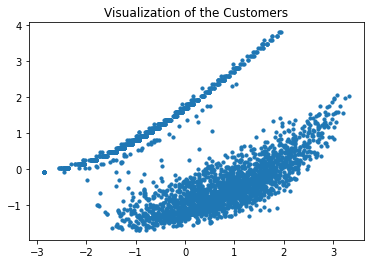

## 

### Analysis of the PCA

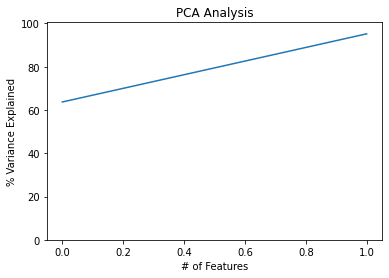

## 

### Gridsearch results

,samples,eps,silhouette,silhouette (w/o noise),|labels| (w/o noise label)
0,40,0.1,0.362425,0.837054,13
1,35,0.1,0.375390,0.832759,14
2,30,0.1,0.400880,0.825919,16
3,25,0.1,0.402289,0.820947,16
4,20,0.1,0.408170,0.820568,17


## 

### Running the experimentation

eps: 0.1, n_samples=40
Labels found (w/o noise):  13


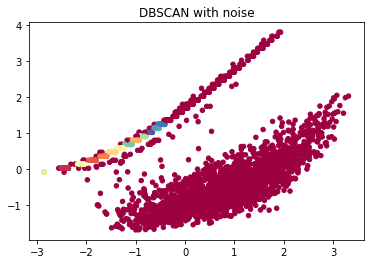

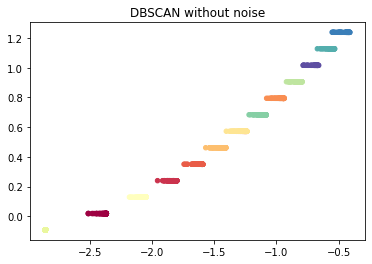

,pc1,pc2,labels
4,-2.378536,0.017680,0
6,-1.801133,0.238797,1
8,-1.593103,0.349629,2
11,-0.940007,0.793569,3
15,-1.433096,0.460625,4
19,-1.277103,0.571635,5
28,-2.049253,0.128101,6
30,-0.682719,1.015774,12
38,-2.855549,-0.092238,7
39,-0.822936,0.904711,8


In [6]:
df = load_dataset(['CustomerID','Mean Days btw Purchases', 'Mean Products In Basket', 'Money Spent Entropy'])
visualize_in_2d(df)
analyze_PCA_dimensions(df)
reduced_df = reduce_df_to_n_dimensions(df, 2)
results = grid_search(df=df, order_by='silhouette (w/o noise)')
run_experiments(df, results)

# Trying on a dataset reduced to 2D

,Money Spent Entropy,Mean Qta Q1,Mean Money Spent Q1,Mean Qta Q2,Mean Money Spent Q2,Mean Qta Q3,Mean Money Spent Q3,Distinct Products,Mean Days btw Purchases,Min Days btw Purchases,Max Days btw Purchases,Max Products In Basket,Min Products In Basket,Mean Products In Basket,Total Products,Distinct Baskets
CustomerID,,,,,,,,,,,,,,,,
12347,1.559384,0.791336,1.097669,1.176657,1.094506,0.960585,0.853072,1.800623,-0.625370,-0.827688,-0.453614,1.338817,-0.381238,0.746764,2.670643,1.092817
12349,0.720174,-0.872030,-0.918653,-0.975782,-1.021626,0.932301,1.074653,0.483574,1.192229,1.191851,1.156081,2.268802,4.771140,3.968380,0.410177,-0.643752
12350,-0.023469,1.799320,1.202418,-0.975782,-1.021626,-1.090054,-1.165732,-0.366135,1.192229,1.191851,1.156081,0.202168,1.447025,0.879159,-0.189539,-0.643752
12352,0.794202,1.503409,1.382503,-0.975782,-1.021626,0.805904,1.235288,0.313632,-0.908171,-1.015924,-0.692087,-0.521153,-0.879855,-0.599254,0.552417,1.092817
12353,-1.723677,-0.872030,-0.918653,0.698337,1.134816,-1.090054,-1.165732,-0.918445,1.192229,1.191851,1.156081,-1.141143,-0.713649,-1.128835,-0.796943,-0.643752


### Visualization in 2D

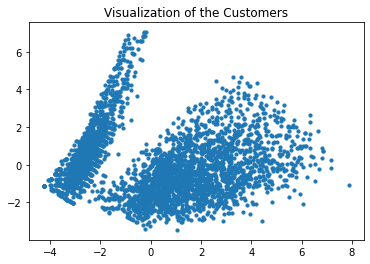

## 

### Analysis of the PCA

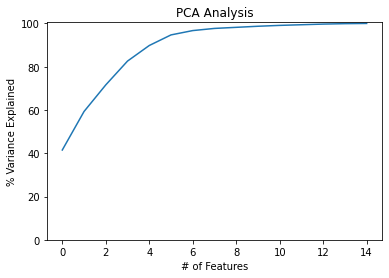

## 

### Gridsearch results

,samples,eps,silhouette,silhouette (w/o noise),|labels| (w/o noise label)
0,25,0.4,0.442906,0.554834,2
1,30,0.4,0.438326,0.569166,2
2,15,0.4,0.438044,0.522557,2
3,35,0.4,0.425854,0.579946,2
4,20,0.3,0.413403,0.589270,2


## 

### Running the experimentation

eps: 0.4, n_samples=25
Labels found (w/o noise):  2


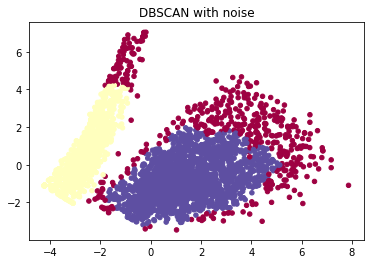

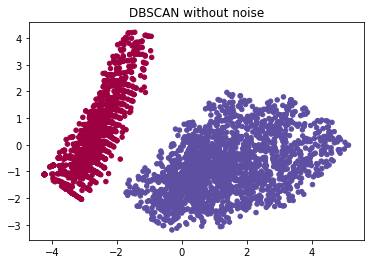

,pc1,pc2,labels
0,4.474079,0.653944,1
2,-1.694325,1.999981,0
3,1.946164,-1.230629,1
4,-3.165389,-1.436492,0
6,-3.628319,-0.215705,0
7,0.352530,-1.827945,1
8,-2.786060,0.086487,0
11,-2.246528,0.583112,0
12,0.693194,-2.514843,1
13,2.099254,-0.716149,1


In [7]:
df = load_dataset()
visualize_in_2d(df)
analyze_PCA_dimensions(df)
reduced_df = reduce_df_to_n_dimensions(df, 2)
results = grid_search(df=reduced_df, order_by='silhouette')
run_experiments(reduced_df, results)

# Trying on a dataset reduced to 2D (selecting according to silhouette w/o noise)

,Money Spent Entropy,Mean Qta Q1,Mean Money Spent Q1,Mean Qta Q2,Mean Money Spent Q2,Mean Qta Q3,Mean Money Spent Q3,Distinct Products,Mean Days btw Purchases,Min Days btw Purchases,Max Days btw Purchases,Max Products In Basket,Min Products In Basket,Mean Products In Basket,Total Products,Distinct Baskets
CustomerID,,,,,,,,,,,,,,,,
12347,1.559384,0.791336,1.097669,1.176657,1.094506,0.960585,0.853072,1.800623,-0.625370,-0.827688,-0.453614,1.338817,-0.381238,0.746764,2.670643,1.092817
12349,0.720174,-0.872030,-0.918653,-0.975782,-1.021626,0.932301,1.074653,0.483574,1.192229,1.191851,1.156081,2.268802,4.771140,3.968380,0.410177,-0.643752
12350,-0.023469,1.799320,1.202418,-0.975782,-1.021626,-1.090054,-1.165732,-0.366135,1.192229,1.191851,1.156081,0.202168,1.447025,0.879159,-0.189539,-0.643752
12352,0.794202,1.503409,1.382503,-0.975782,-1.021626,0.805904,1.235288,0.313632,-0.908171,-1.015924,-0.692087,-0.521153,-0.879855,-0.599254,0.552417,1.092817
12353,-1.723677,-0.872030,-0.918653,0.698337,1.134816,-1.090054,-1.165732,-0.918445,1.192229,1.191851,1.156081,-1.141143,-0.713649,-1.128835,-0.796943,-0.643752


### Visualization in 2D

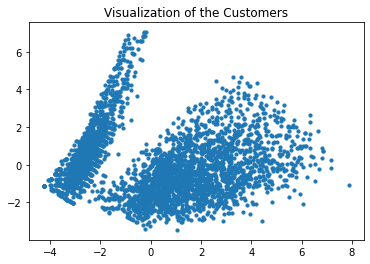

## 

### Analysis of the PCA

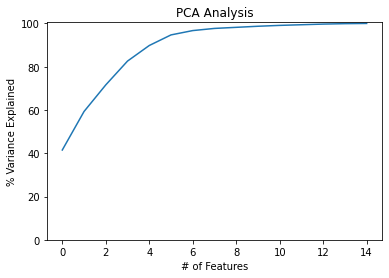

## 

### Gridsearch results

,samples,eps,silhouette,silhouette (w/o noise),|labels| (w/o noise label)
0,30,0.1,0.073672,0.967373,2
1,40,0.3,0.281835,0.649866,2
2,20,0.3,0.413403,0.589270,2
3,35,0.4,0.425854,0.579946,2
4,30,0.4,0.438326,0.569166,2


## 

### Running the experimentation

eps: 0.1, n_samples=30
Labels found (w/o noise):  2


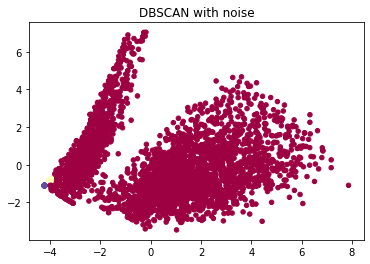

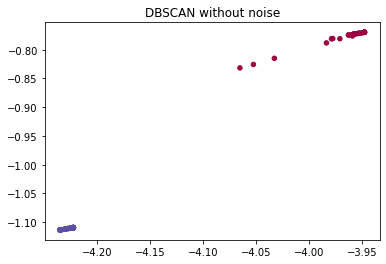

,pc1,pc2,labels
44,-3.947621,-0.769665,0
133,-4.222148,-1.109380,1
139,-3.952631,-0.771259,0
162,-4.224653,-1.110177,1
201,-4.234674,-1.113365,1
345,-4.229664,-1.111771,1
350,-4.222148,-1.109380,1
482,-4.222148,-1.109380,1
485,-4.222148,-1.109380,1
496,-3.957642,-0.772854,0


In [8]:
df = load_dataset()
visualize_in_2d(df)
analyze_PCA_dimensions(df)
reduced_df = reduce_df_to_n_dimensions(df, 2)
results = grid_search(df=reduced_df, order_by='silhouette (w/o noise)')
run_experiments(reduced_df, results)